### ARIMA-TimeSeries Analysis of Tractor Sales

In this case study example, we will learn about time series analysis for a manufacturing operation. Time series analysis and modeling have many business and social applications. It is extensively used to forecast company sales, product demand, stock market trends, agricultural production etc.

The fundamental idea for time series analysis is to decompose the original time series (sales, stock market trends, etc.) into several independent components. Typically, business time series are divided into the following four components:

- Trend – overall direction of the series i.e. upwards, downwards etc.
- Seasonality – monthly or quarterly patterns
- Cycle – long-term business cycles, they usually come after 5 or 7 years
- Irregular remainder – random noise left after extraction of all the components

Interference of these components produces the final series.

Why bother decomposing the original / actual time series into components? It is much easier to forecast the individual regular patterns produced through decomposition of time series than the actual series.

#### Step 0: Problem Definition
PowerHorse, a tractor and farm equipment manufacturing company, was established a few years after World War II. The company has shown a consistent growth in its revenue from tractor sales since its inception. However, over the years the company has struggled to keep it’s inventory and production cost down because of variability in sales and tractor demand. The management at PowerHorse is under enormous pressure from the shareholders and board to reduce the production cost. Additionally, they are also interested in understanding the impact of their marketing and farmer connect efforts towards overall sales. In the same effort, they have hired us as a data science and predictive analytics consultant.

We will develop an ARIMA model to forecast sale / demand of tractor for next 3 years. Additionally, We will also investigate the impact of marketing program on sales by using an exogenous variable ARIMA model.

As a part of this project, one of the production units we are analysing is based in South East Asia. This unit is completely independent and caters to neighbouring geographies. This unit is just a decade and a half old. In 2014 , they captured 11% of the market share, a 14% increase from the previous year. However, being a new unit they have very little bargaining power with their suppliers to implement Just-in-Time (JiT) manufacturing principles that have worked really well in PowerHorse’s base location. Hence, they want to be on top of their production planning to maintain healthy business margins. Monthly sales forecast is the first step we have suggested to this unit towards effective inventory management.

The MIS team shared the month on month (MoM) sales figures (number of tractors sold) for the last 12 years in the tractor-sales.csv file.

In [28]:
import warnings
import itertools

import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('bmh')

#### Step 1: Visualize Tractor Sales data as time series

In [29]:
from io import StringIO
import requests

sales_data = pd.read_csv("Sales-and-Marketing.csv")
sales_data.head(5)

,Time Period,Sales,Marketing Expense
0,Jan-11,397,486.64
1,Feb-11,400,501.80
2,Mar-11,498,437.09
3,Apr-11,536,565.16
4,May-11,596,744.15


In [30]:
# since the complete date was not mentioned, we assume that it was the first of every month
dates = pd.date_range(start='2011-01-01', freq='MS', periods=len(sales_data))

In [31]:
dates

DatetimeIndex(['2011-01-01', '2011-02-01', '2011-03-01', '2011-04-01',
               '2011-05-01', '2011-06-01', '2011-07-01', '2011-08-01',
               '2011-09-01', '2011-10-01', '2011-11-01', '2011-12-01',
               '2012-01-01', '2012-02-01', '2012-03-01', '2012-04-01',
               '2012-05-01', '2012-06-01', '2012-07-01', '2012-08-01',
               '2012-09-01', '2012-10-01', '2012-11-01', '2012-12-01',
               '2013-01-01', '2013-02-01', '2013-03-01', '2013-04-01',
               '2013-05-01', '2013-06-01', '2013-07-01', '2013-08-01',
               '2013-09-01', '2013-10-01', '2013-11-01', '2013-12-01',
               '2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01',
               '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01',
               '2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01'],
              dtype='datetime64[ns]', freq='MS')

In [32]:
import calendar
sales_data['Month'] = dates.month
sales_data['Month'] = sales_data['Month'].apply(lambda x: calendar.month_abbr[x])
sales_data['Year'] = dates.year

In [33]:
sales_data.head()

,Time Period,Sales,Marketing Expense,Month,Year
0,Jan-11,397,486.64,Jan,2011
1,Feb-11,400,501.80,Feb,2011
2,Mar-11,498,437.09,Mar,2011
3,Apr-11,536,565.16,Apr,2011
4,May-11,596,744.15,May,2011


In [34]:
sales_data.drop(['Time Period'], axis=1, inplace=True)
sales_data = sales_data[['Month', 'Year', 'Sales', 'Marketing Expense']]

In [35]:
sales_data

,Month,Year,Sales,Marketing Expense
0,Jan,2011,397,486.64
1,Feb,2011,400,501.80
2,Mar,2011,498,437.09
3,Apr,2011,536,565.16
4,May,2011,596,744.15
5,Jun,2011,591,548.74
6,Jul,2011,651,650.21
7,Aug,2011,654,777.51
8,Sep,2011,509,547.11
9,Oct,2011,437,382.81


In [36]:
# set the dates as the index of the dataframe, so that it can be treated as a time-series dataframe
sales_data.set_index(dates, inplace=True)

In [37]:
# check out first 5 samples of the data
sales_data.head(5)

,Month,Year,Sales,Marketing Expense
2011-01-01,Jan,2011,397,486.64
2011-02-01,Feb,2011,400,501.80
2011-03-01,Mar,2011,498,437.09
2011-04-01,Apr,2011,536,565.16
2011-05-01,May,2011,596,744.15


In [38]:
# extract out the time-series
sales_ts = sales_data['Sales']

Text(0,0.5,'Tractor Sales')

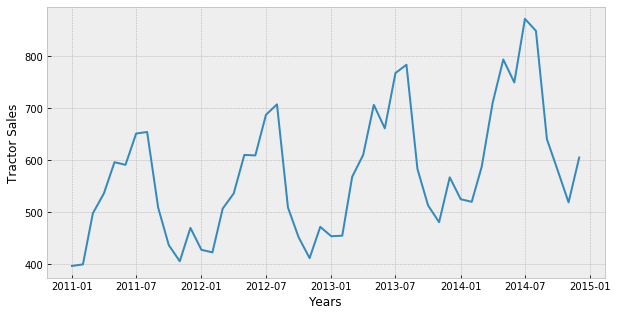

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(sales_ts)
plt.xlabel('Years')
plt.ylabel('Tractor Sales')

Now we start with time series decomposition of this data to understand underlying patterns such as trend, seasonality, cycle and irregular remainder for tractor sales.

In the above data, a cyclic pattern seems to be non-existent since the unit we are analysing is a relatively new unit to notice business cycles. Also in theory, business cycles in traditional businesses are observed over a period of 7 or more years. Hence, we won’t include business cycles in this time series decomposition exercise. Also, we observe a overall increasing trend across years. We will build our model based on the following function:

- Yt=f(Trendt,Seasonalityt,Remaindert)
- Yt=f(Trendt,Seasonalityt,Remaindert)
 
Step 1.1: Trend - Time Series Decomposition
Now, to begin with let's try to decipher trends embedded in the above tractor sales time series. It is clearly evident that there is an overall increasing trend in the data along with some seasonal variations. However, it might not always be possible to make such visual inferences. So, more formally, we can check stationarity using the following:
Plotting Rolling Statistics: We can plot the moving average or moving variance and see if it varies with time. By moving average/variance we mean that at any instant 't', we'll take the average/variance of the last year, i.e. last 12 months. But again this is more of a visual technique.

Dickey-Fuller Test: This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.
Moving Average - A good analogy for moving average is ironing clothes to remove wrinkles. The idea with moving average is to remove all the zigzag motion (wrinkles) from the time series to produce a steady trend through averaging adjacent values of a time period. Hence, the formula for moving average is:

MovingAverage=∑mi=−mYt+i2m
MovingAverage=∑i=−mmYt+i2m
 
Now, let’s try to remove wrinkles from our time series using moving average. We will take moving average of different time periods i.e. 4,6,8, and 12 months as shown below. Here, moving average is shown in red and actual series in blue.

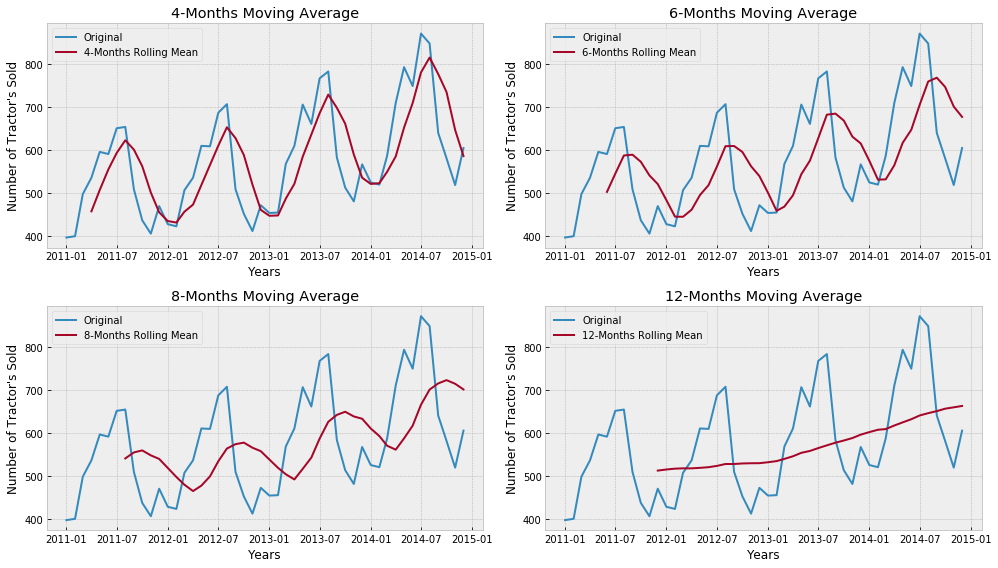

In [40]:
fig, axes = plt.subplots(2, 2, sharey=False, sharex=False)
fig.set_figwidth(14)
fig.set_figheight(8)

axes[0][0].plot(sales_ts.index, sales_ts, label='Original')
axes[0][0].plot(sales_ts.index, sales_ts.rolling(window=4).mean(), label='4-Months Rolling Mean')
axes[0][0].set_xlabel("Years")
axes[0][0].set_ylabel("Number of Tractor's Sold")
axes[0][0].set_title("4-Months Moving Average")
axes[0][0].legend(loc='best')

axes[0][1].plot(sales_ts.index, sales_ts, label='Original')
axes[0][1].plot(sales_ts.index, sales_ts.rolling(window=6).mean(), label='6-Months Rolling Mean')
axes[0][1].set_xlabel("Years")
axes[0][1].set_ylabel("Number of Tractor's Sold")
axes[0][1].set_title("6-Months Moving Average")
axes[0][1].legend(loc='best')

axes[1][0].plot(sales_ts.index, sales_ts, label='Original')
axes[1][0].plot(sales_ts.index, sales_ts.rolling(window=8).mean(), label='8-Months Rolling Mean')
axes[1][0].set_xlabel("Years")
axes[1][0].set_ylabel("Number of Tractor's Sold")
axes[1][0].set_title("8-Months Moving Average")
axes[1][0].legend(loc='best')

axes[1][1].plot(sales_ts.index, sales_ts, label='Original')
axes[1][1].plot(sales_ts.index, sales_ts.rolling(window=12).mean(), label='12-Months Rolling Mean')
axes[1][1].set_xlabel("Years")
axes[1][1].set_ylabel("Number of Tractor's Sold")
axes[1][1].set_title("12-Months Moving Average")
axes[1][1].legend(loc='best')

plt.tight_layout()
plt.show()

As we could see in the above plots, 12-month moving average could produce a wrinkle free curve as desired. This on some level is expected since we are using month-wise data for our analysis and there is expected monthly-seasonal effect in our data.

Let's plot the rolling mean and standard deviation on window of 12 months.

### Dickey-Fuller Test 
- Let's run the Dicky Fuller Test on the timeseries and verify the null hypothesis that the TS is non-stationary.

In [41]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    """
    Pass in a time series, returns ADF report
    """
    #Determing rolling statistics
    ts=timeseries
    rolmean = ts.rolling(window = 12).mean()
    rolstd = ts.rolling(window = 12).std()
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion: strong evidence against the null hypothesis, reject the null hypothesis. Time Series is stationary")
    else:
        print("Conclusion: weak evidence against null hypothesis,indicating time series is non-stationary ")

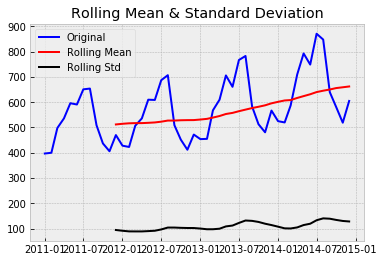

Results of Dickey-Fuller Test:
Test Statistic                  1.434334
p-value                         0.997265
#Lags Used                     10.000000
Number of Observations Used    37.000000
Critical Value (1%)            -3.620918
Critical Value (5%)            -2.943539
Critical Value (10%)           -2.610400
dtype: float64
Conclusion: weak evidence against null hypothesis,indicating time series is non-stationary 


In [42]:
test_stationarity(sales_ts)

In [43]:
decomposition = sm.tsa.seasonal_decompose(sales_ts, model='multiplicative')

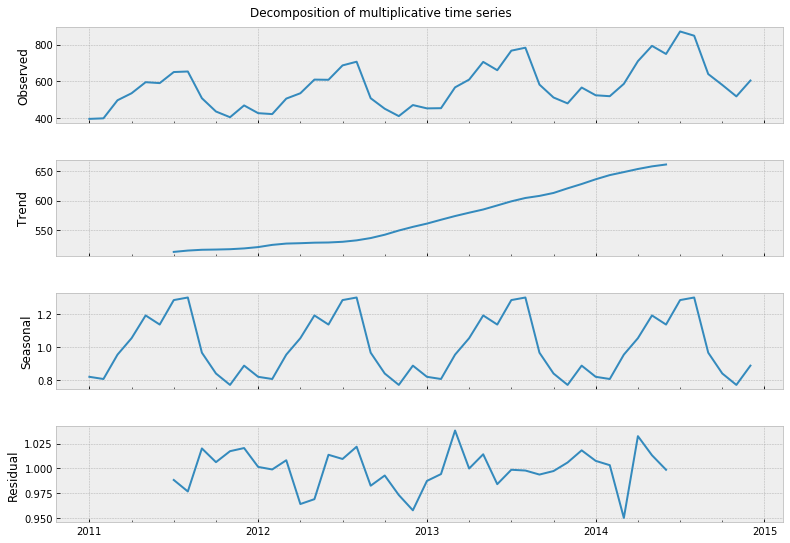

In [44]:
fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of multiplicative time series')
plt.show()

The following are some of our key observations from this analysis:
1) Trend: 12-months moving average looks quite similar to a straight line hence we could have easily used linear regression to estimate the trend in this data.
2) Seasonality: As discussed, seasonal plot displays a fairly consistent month-on-month pattern. The monthly seasonal components are average values for a month after removal of trend. Trend is removed from the time series using the following formula:

- Seasonalityt×Remaindert=YtTrendt

 
3) Irregular Remainder (random): is the residual left in the series after removal of trend and seasonal components. Remainder is calculated using the following formula:

- Remaindert=YtTrendt×Seasonalityt
 
The expectations from remainder component is that it should look like a white noise i.e. displays no pattern at all. However, for our series residual display some pattern with high variation on the edges of data i.e. near the beginning (2004-07) and the end (2013-14) of the series.

#### ARIMA Modeling
ARIMA is a combination of 3 parts i.e. AR (AutoRegressive), I (Integrated), and MA (Moving Average). A convenient notation for ARIMA model is ARIMA(p,d,q). Here p,d, and q are the levels for each of the AR, I, and MA parts. Each of these three parts is an effort to make the final residuals display a white noise pattern (or no pattern at all). In each step of ARIMA modeling, time series data is passed through these 3 parts like a sugar cane through a sugar cane juicer to produce juice-less residual. The sequence of three passes for ARIMA analysis is as following:

1st Pass of ARIMA to Extract Juice / Information
Integrated (I) – subtract time series with its lagged series to extract trends from the data
In this pass of ARIMA juicer, we extract trend(s) from the original time series data. Differencing is one of the most commonly used mechanisms for extraction of trends. Here, the original series is subtracted with it’s lagged series e.g. November’s sales values are subtracted with October’s values to produce trend-less residual series. The formulae for different orders of differencing are as follow:

- No Differencing (d=0) |  Y′t=YtYt′=Yt 
- 1st Differencing (d=1) |  Y′t=Yt−Yt−1Yt′=Yt−Yt−1 
- 2nd Differencing (d=1) |  Y′t=Yt−Yt−1−(Yt−1−Yt−2)=Yt−2×Yt−1+Yt−2Yt′=Yt−Yt−1−(Yt−1−Yt−2)=Yt−2×Yt−1+Yt−2 

For example, in the below plot a time series data with a linearly upward trend is displayed. Adjacent to that plot is the 1st order differenced plot for the same data. As we can notice after 1st order differencing, trend part of the series is extracted and the difference data (residual) does not display any trend.

In [45]:
sales_ts_log = np.log(sales_ts)
sales_ts_log.dropna(inplace=True)

sales_ts_log_diff = sales_ts_log.diff(periods=1) # same as ts_log_diff = ts_log - ts_log.shift(periods=1)
sales_ts_log_diff.dropna(inplace=True)

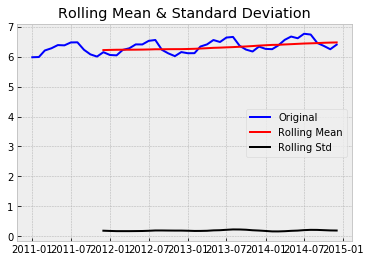

Results of Dickey-Fuller Test:
Test Statistic                  0.897455
p-value                         0.993057
#Lags Used                     10.000000
Number of Observations Used    37.000000
Critical Value (1%)            -3.620918
Critical Value (5%)            -2.943539
Critical Value (10%)           -2.610400
dtype: float64
Conclusion: weak evidence against null hypothesis,indicating time series is non-stationary 


In [46]:
test_stationarity(sales_ts_log)

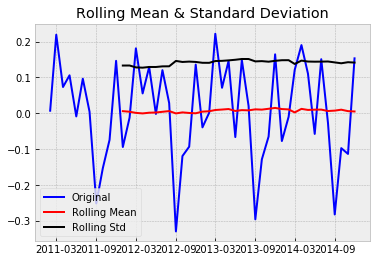

Results of Dickey-Fuller Test:
Test Statistic                -5.871527e+00
p-value                        3.231745e-07
#Lags Used                     1.000000e+01
Number of Observations Used    3.600000e+01
Critical Value (1%)           -3.626652e+00
Critical Value (5%)           -2.945951e+00
Critical Value (10%)          -2.611671e+00
dtype: float64
Conclusion: strong evidence against the null hypothesis, reject the null hypothesis. Time Series is stationary


In [47]:
test_stationarity(sales_ts_log_diff)

In [48]:
sales_ts_log_diff2=sales_ts_log_diff.diff(periods=1)

In [49]:
sales_ts_log_diff2.dropna(inplace=True)

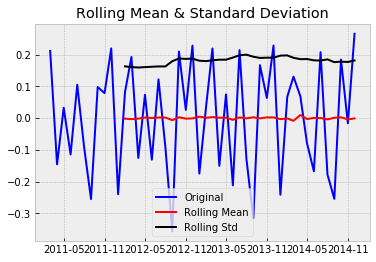

Results of Dickey-Fuller Test:
Test Statistic                -1.391787e+01
p-value                        5.362325e-26
#Lags Used                     1.000000e+01
Number of Observations Used    3.500000e+01
Critical Value (1%)           -3.632743e+00
Critical Value (5%)           -2.948510e+00
Critical Value (10%)          -2.613017e+00
dtype: float64
Conclusion: strong evidence against the null hypothesis, reject the null hypothesis. Time Series is stationary


In [50]:
test_stationarity(sales_ts_log_diff2)

C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


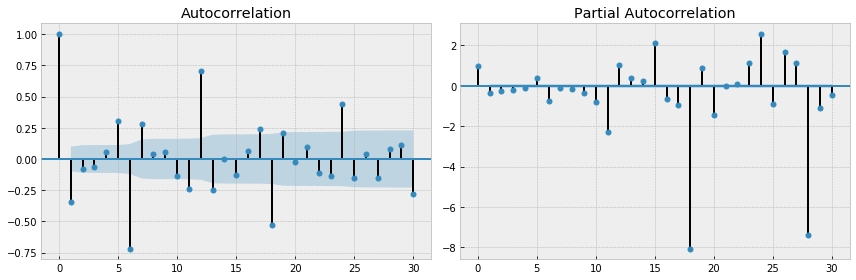

In [51]:
fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(sales_ts_log_diff2, lags=30, ax=axes[0], alpha=0.5)
smt.graphics.plot_pacf(sales_ts_log_diff2, lags=30, ax=axes[1], alpha=0.5)
plt.tight_layout()

Since, there are enough spikes in the plots outside the insignificant zone (dotted horizontal lines) we can conclude that the residuals are not random. This implies that there is juice or information available in residuals to be extracted by AR and MA models. Also, there is a seasonal component available in the residuals at the lag 12 (represented by spikes at lag 12). This makes sense since we are analyzing monthly data that tends to have seasonality of 12 months because of patterns in tractor sales.

#### Step 6: Identification of best fit ARIMA model

In order to fit the time series data with a seasonal ARIMA model, we need to first find the the values of ARIMA(p,d,q)(P,D,Q)s that optimize a metric of interest such as AIC or BIC. There are many guidelines and best practices to achieve this goal, yet the correct parametrization of ARIMA models can be a painstaking manual process that requires domain expertise and time. Auto arima function in forecast package in R helps us identify the best fit ARIMA model on the fly but in Python we will generate combination of p,d and q to select the optimal parameter values for our ARIMA(p,d,q)(P,D,Q)s time series model.
This technique is known as "grid search" where we iteratively explore different combinations of parameters. For each such combination of parameters, we try to fit a new seasonal ARIMA model with the SARIMAX() function from the statsmodels module and assess AIC or BIC score. The model with the best score wins and the parmeters for that model are the optimal parmeters.

#### Akaike Information Criterion (AIC) 
- AIC is an effort to balance the model between goodness-of-fit and number of parameters used in the model. This is similar to the balancing act between income and cost of a company so that the debs of the company is optimized (Debt = Cost - Income). As a modeler, we care about the maximum goodness of fit (income) with the minimum number of parameters (cost).

AIC=2K−2ln(L)AIC=2K−2ln(L) 

For the given model, L in the above formula is the maximized value of the likelihood function representing goodness-of-fit, and K the number of estimated parameters. Like our debts, we want to keep AIC value at the minimum to choose the best possible model. Bayesian Information Criterion (BIC) is another variant of AIC and is used for the same purpose of best fit model selection. For the best possible model selection, we want to look at AIC, BIC, and AICc (AIC with sample correction) if all these values are minimum for a given model. With increasing parameters K will increase and hence AIC increases. While with the goodness of the fit L increases thus decreasing AIC.

As expected, our model has I (or integrated) component equal to 1. This represents differencing of order 1. There is additional differencing of lag 12 in the above best fit model. Moreover, the best fit model has MA value of order 1. Also, there is seasonal MA with lag 12 of order 1.

The model that we got here is different from the one that was discussed in the blog. Let us validate that model with ours how does that perform with statsmodel as well as our model.

#### Step 10: Regression with ARIMAX
For the last 4 years, PowerHorse tractors is running an expensive marketing and farmer connect program to boost their sales. They are interested in learning the impact of this program on overall sales. As a data science consultant we are helping them with this effort. This is an interesting problem and requires a thorough analysis followed by creative solutions and scientific monitoring mechanism. To begin with we will build models based on regression with ARIMA errors and compare them with the pure play ARIMA model. This analysis will provide some clues towards effectiveness of the marketing program. However, this analysis will not be conclusive for finding shortcomings and enhancements for the program which will require further analysis and creative solutions.

To begin with, we plot the following scatter plot of same months marketing expense and tractors sales.

In [53]:
sales_data.columns

Index(['Month', 'Year', 'Sales', 'Marketing Expense'], dtype='object')

Text(0,0.5,'Monthly Tractor Sales')

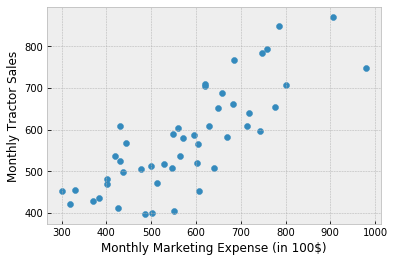

In [54]:
plt.figure()
plt.scatter(x=sales_data['Marketing Expense'], y=sales_data['Sales'])
plt.xlabel('Monthly Marketing Expense (in 100$)')
plt.ylabel('Monthly Tractor Sales')

In [56]:
print("Correlation for Marketing Data: {}".format(round(sales_data.corr()['Marketing Expense']['Sales'], 2)))

Correlation for Marketing Data: 0.8


This looks promising with quite a high correlation coefficient ( ρρ  > 0.8). However, there is a lurking danger in analyzing non-stationary time series data. Since two uncorrelated series can display high correlation because of time series trend in data. In this case, PowerHorse is a growing company and the latent factor is 'growth' of the company. Hence both its sales and marketing expenses can be on an upward curve independent of each other. To investigat that a better way is to find the correlation between stationary data obtained through differencing of marketing expediture and the trator sales data individually.

The following is the correlation plot for stationary data:

In [57]:
sales_data.shift()

,Month,Year,Sales,Marketing Expense
2011-01-01,NaN,NaN,NaN,NaN
2011-02-01,Jan,2011.0,397.0,486.64
2011-03-01,Feb,2011.0,400.0,501.80
2011-04-01,Mar,2011.0,498.0,437.09
2011-05-01,Apr,2011.0,536.0,565.16
2011-06-01,May,2011.0,596.0,744.15
2011-07-01,Jun,2011.0,591.0,548.74
2011-08-01,Jul,2011.0,651.0,650.21
2011-09-01,Aug,2011.0,654.0,777.51
2011-10-01,Sep,2011.0,509.0,547.11


In [58]:
sales_data['MS_Previous']= sales_data['Marketing Expense'].shift()

In [59]:
sales_data.head()

,Month,Year,Sales,Marketing Expense,MS_Previous
2011-01-01,Jan,2011,397,486.64,NaN
2011-02-01,Feb,2011,400,501.80,486.64
2011-03-01,Mar,2011,498,437.09,501.80
2011-04-01,Apr,2011,536,565.16,437.09
2011-05-01,May,2011,596,744.15,565.16


In [60]:
sales_data.dropna(inplace=True)

Text(0,0.5,'Tractor Sales')

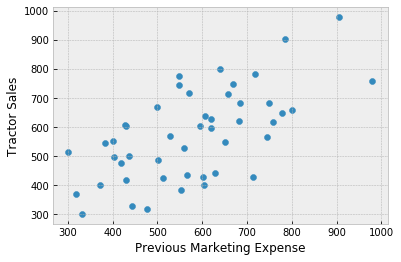

In [61]:
plt.figure()
plt.scatter(x=sales_data['Marketing Expense'], y=sales_data['MS_Previous'])
plt.xlabel('Previous Marketing Expense')
plt.ylabel('Tractor Sales')

In [62]:
np.corrcoef(sales_data['MS_Previous'], sales_data['Marketing Expense'])

array([[1.        , 0.62741982],
       [0.62741982, 1.        ]])

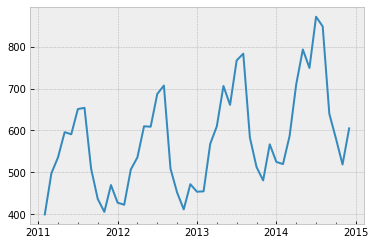

In [64]:
sales_data['Sales'].plot()

In [65]:
sales_data['Sales_diff'] = sales_data['Sales']- sales_data['Sales'].shift()

In [66]:
sales_data.dropna(inplace=True)

sales_data['Mkt_Exp']  = sales_data['Sales']
sales_data['Mkt_Exp_Lag1']  = sales_data['Sales'].shift(1)
sales_data['Mkt_Exp_Lag2']  = sales_data['Sales'].shift(2)
sales_data['Mkt_Exp_Lag3']  = sales_data['Sales'].shift(3)
sales_data['Mkt_Exp_Lag4']  = sales_data['Sales'].shift(4)


In [67]:
sales_data.dropna(inplace=True)

In [68]:
sales_data.head()

,Month,Year,Sales,Marketing Expense,MS_Previous,Sales_diff,Mkt_Exp,Mkt_Exp_Lag1,Mkt_Exp_Lag2,Mkt_Exp_Lag3,Mkt_Exp_Lag4
2011-07-01,Jul,2011,651,650.21,548.74,60.0,651,591.0,596.0,536.0,498.0
2011-08-01,Aug,2011,654,777.51,650.21,3.0,654,651.0,591.0,596.0,536.0
2011-09-01,Sep,2011,509,547.11,777.51,-145.0,509,654.0,651.0,591.0,596.0
2011-10-01,Oct,2011,437,382.81,547.11,-72.0,437,509.0,654.0,651.0,591.0
2011-11-01,Nov,2011,406,551.56,382.81,-31.0,406,437.0,509.0,654.0,651.0


In [69]:
import sys

def auto_arima(timeseries, regressors=None, p=range(0, 2), d=range(0, 1), q=range(0, 2)):

    # Generate all different combinations of p, d and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    
    warnings.filterwarnings("ignore") # specify to ignore warning messages

    best_aic = np.inf
    best_pdq = None
    best_seasonal_pdq = None
    best_results = None

    for param in pdq:
        for param_seasonal in seasonal_pdq:

            try:
                temp_model = sm.tsa.statespace.SARIMAX(endog=timeseries,
                                                 exog=regressors,
                                                 order = param,
                                                 seasonal_order = param_seasonal,
                                                 enforce_stationarity=False,
                                                 enforce_invertibility=False)
                temp_results = temp_model.fit()

                # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
                if temp_results.aic < best_aic:
                    best_aic = temp_results.aic
                    best_pdq = param
                    best_seasonal_pdq = param_seasonal
                    best_results = temp_results
            except:
                #print("Unexpected error:", sys.exc_info()[0])
                continue
                
                

    print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))
    print(best_results.summary().tables[0])
    print(best_results.summary().tables[1])

In [70]:
#ARIMA Model No Regressor
timeseries = sales_data['Sales']
auto_arima(timeseries,  p=range(0, 3), d=range(0, 2), q=range(0, 3))

Best SARIMAX(2, 1, 0)x(2, 1, 0, 12)12 model - AIC:-7.311001000366851
                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                   42
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 12)   Log Likelihood                   8.656
Date:                            Sat, 17 Nov 2018   AIC                             -7.311
Time:                                    22:38:29   BIC                            -11.818
Sample:                                07-01-2011   HQIC                           -16.371
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -3.1506      0.000   -1.4e+04  

In [71]:
#ARIMA Model No Regressor
timeseries = sales_data['Sales']
regressors = sales_data['Mkt_Exp']
auto_arima(timeseries, regressors=regressors, p=range(0, 3), d=range(0, 2), q=range(0, 3))

Best SARIMAX(0, 0, 1)x(1, 1, 0, 12)12 model - AIC:-944.3985544197604
                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                   42
Model:             SARIMAX(0, 0, 1)x(1, 1, 0, 12)   Log Likelihood                 476.199
Date:                            Sat, 17 Nov 2018   AIC                           -944.399
Time:                                    22:38:45   BIC                           -940.837
Sample:                                07-01-2011   HQIC                          -943.907
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Mkt_Exp        1.0000   5.69e-17   1.76e+16  

In [72]:
#ARIMA Model with 1 month Lag Marekting Sales Data Regressor
timeseries = sales_data['Sales']
regressors = sales_data[['Mkt_Exp', 'Mkt_Exp_Lag1']]
auto_arima(timeseries, regressors=regressors, p=range(0, 3), d=range(0, 2), q=range(0, 3))

Best SARIMAX(1, 0, 0)x(0, 0, 0, 12)12 model - AIC:-2405.7790610761585
                           Statespace Model Results                           
Dep. Variable:                  Sales   No. Observations:                   42
Model:               SARIMAX(1, 0, 0)   Log Likelihood                1206.890
Date:                Sat, 17 Nov 2018   AIC                          -2405.779
Time:                        22:39:35   BIC                          -2398.925
Sample:                    07-01-2011   HQIC                         -2403.283
                         - 12-01-2014                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Mkt_Exp          1.0000   1.01e-16   9.87e+15      0.000       1.000       1.000
Mkt_Exp_Lag1 -1.388e-16   1.11e-16     -1.251      0.21

In [73]:
#ARIMA Model with 2 months Lag Marekting Sales Data Regressor
timeseries = sales_data['Sales']
regressors = sales_data[['Mkt_Exp', 'Mkt_Exp_Lag1', 'Mkt_Exp_Lag2']]
auto_arima(timeseries, regressors=regressors, p=range(0, 3), d=range(0, 2), q=range(0, 3))

Best SARIMAX(1, 0, 0)x(0, 0, 0, 12)12 model - AIC:-2412.595173446863
                           Statespace Model Results                           
Dep. Variable:                  Sales   No. Observations:                   42
Model:               SARIMAX(1, 0, 0)   Log Likelihood                1211.298
Date:                Sat, 17 Nov 2018   AIC                          -2412.595
Time:                        22:40:21   BIC                          -2404.027
Sample:                    07-01-2011   HQIC                         -2409.475
                         - 12-01-2014                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Mkt_Exp          1.0000   1.22e-16   8.19e+15      0.000       1.000       1.000
Mkt_Exp_Lag1   2.03e-16   4.28e-17      4.742      0.000

In [59]:
# We have choosen final model with two regressors (MS, MS_Lag1) based on improvement in AIC
#(1, 0, 0)x(0, 0, 0, 12)

In [60]:
smt.SARIMAX?

In [92]:
timeseries = sales_data['Sales']
regressors = sales_data[['Mkt_Exp', 'Mkt_Exp_Lag1']]


model = smt.SARIMAX(timeseries, exog = regressors, order=(1,0,0), seasonal_order=(0,0,0,12))
results = model.fit()
print(results.summary())

                           Statespace Model Results                           
Dep. Variable:                  Sales   No. Observations:                   42
Model:               SARIMAX(1, 0, 0)   Log Likelihood                1236.660
Date:                Sat, 17 Nov 2018   AIC                          -2465.320
Time:                        22:56:45   BIC                          -2458.369
Sample:                    07-01-2011   HQIC                         -2462.772
                         - 12-01-2014                                         
Covariance Type:                  opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Mkt_Exp          1.0000   1.01e-16   9.87e+15      0.000       1.000       1.000
Mkt_Exp_Lag1 -1.388e-16   1.11e-16     -1.252      0.211   -3.56e-16    7.85e-17
ar.L1            0.4643   6.64e-20   6.99e+1

#### Step 7: Predict sales on in-sample date using the best fit ARIMA model
The next step is to predict tractor sales for in-sample data and find out how close is the model prediction on the in-sample data to the actual truth.

In [102]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 42 entries, 2011-07-01 to 2014-12-01
Freq: MS
Data columns (total 12 columns):
Month                42 non-null object
Year                 42 non-null int64
Sales                42 non-null int64
Marketing Expense    42 non-null float64
MS_Previous          42 non-null float64
Sales_diff           42 non-null float64
Mkt_Exp              42 non-null int64
Mkt_Exp_Lag1         42 non-null float64
Mkt_Exp_Lag2         42 non-null float64
Mkt_Exp_Lag3         42 non-null float64
Mkt_Exp_Lag4         42 non-null float64
Sales_predict        42 non-null float64
dtypes: float64(8), int64(3), object(1)
memory usage: 5.5+ KB


In [111]:
# Extract the predicted and true values of our time series
#sales_data['Sales_predict'] = results.predict()

sales_data['predict_existing'] = results.predict(start = 1, end= 41, dynamic= True)  


In [112]:
mse = ((sales_data['Sales']*1.0- sales_data['predict_existing'] )** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))

The Mean Squared Error of our forecasts is 0.0
